# Self-Supervised Learning with SimCLR on CIFAR-10

## 📌 Introduction

In this notebook, we explore **Self-Supervised Learning (SSL)**, a powerful training paradigm that allows neural networks to learn useful representations **without relying on human-labeled data**.

We implement a simplified version of the **SimCLR (Simple Contrastive Learning of Representations)** framework and apply it to the **CIFAR-10 dataset**. SimCLR uses **contrastive learning** to train a model by maximizing agreement between two different augmented views of the same image.

---

## 🚀 Objectives

- Understand the core principles of **self-supervised contrastive learning**.
- Implement a simple version of **SimCLR** using PyTorch.
- Learn to train a model using **positive pairs (same image, different augmentations)** and **negative pairs (other images)**.
- Visualize the **learned representations** using **t-SNE**, to verify that the model clusters semantically similar images together — without seeing any labels during training.

---

## 🧱 Key Components

- **Augmentation Strategy**: Generates two different views of each image to form a positive pair.
- **Encoder Network**: A convolutional neural network (ResNet-18) that extracts image features.
- **Projection Head**: A small MLP that maps representations to a latent space where contrastive loss is applied.
- **Contrastive Loss**: NT-Xent loss that encourages similar images to have close embeddings and different images to be far apart.
- **t-SNE Visualization**: Helps us interpret how well the learned features group similar classes in 2D space.

---

## 🧪 Dataset: CIFAR-10

CIFAR-10 contains 60,000 32×32 color images across 10 classes (airplane, car, bird, etc.).  
This notebook **does not use labels during training** — labels are only used for post-hoc visualization.

---

By the end of this notebook, you'll gain hands-on experience in:
- Building a self-supervised learning pipeline
- Training a neural network without labeled supervision
- Understanding how learned features can be visualized and interpreted

Let’s get started! 👇


## Install and import necessary libraries


In [1]:
# !pip install torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as T
import torchvision.datasets as datasets
import torchvision.models as models
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

## Define the augmentation pipeline


In [2]:
# This simulates "views" of the same image (e.g., cropping, flipping)
transform = T.Compose([
    T.RandomResizedCrop(32),
    T.RandomHorizontalFlip(),
    T.ColorJitter(0.5, 0.5, 0.5, 0.2),
    T.ToTensor()
])


## Define a dataset that returns *two views* of the same image

### ContrastiveDataset: Generating Positive Pairs
This custom dataset wrapper is designed for contrastive self-supervised learning (like SimCLR). Instead of returning just one version of each image, it returns two different augmented views of the same original image.
```
return transform(img), transform(img)
```
These two views are called a positive pair.

The model is trained to learn that both views represent the same underlying concept.

From the perspective of learning:

- ❌ No labels are used.

- ✅ Only the invariance across augmentations is exploited for supervision.

- 🎯 The model must learn to associate these two views, and disassociate them from views of other images (negatives).

This is the foundation for contrastive self-supervised learning.

In [3]:
class ContrastiveDataset(torch.utils.data.Dataset):
    def __init__(self, dataset):
        self.dataset = dataset

    def __getitem__(self, index):
        img, _ = self.dataset[index]
        return transform(img), transform(img)  # two views

    def __len__(self):
        return len(self.dataset)

## Load CIFAR-10 dataset with ContrastiveDataset wrapper

In [4]:
base_dataset = datasets.CIFAR10(root='./data', train=True, download=True)
contrastive_dataset = ContrastiveDataset(base_dataset)
loader = DataLoader(contrastive_dataset, batch_size=256, shuffle=True, num_workers=2)

100%|██████████| 170M/170M [00:02<00:00, 76.4MB/s]


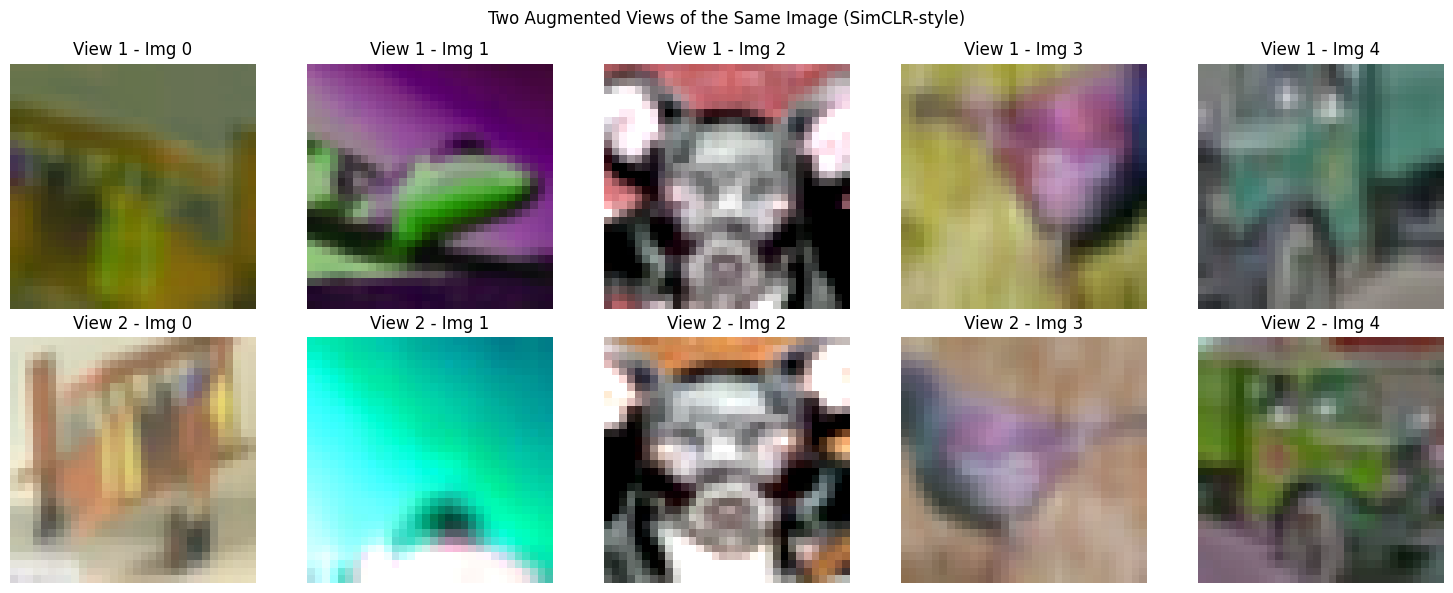

In [5]:
import matplotlib.pyplot as plt

# Get one batch of image pairs
sample_loader = DataLoader(contrastive_dataset, batch_size=5, shuffle=True)
img1_batch, img2_batch = next(iter(sample_loader))

# Plot original vs augmented views
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
for i in range(5):
    # First row: one view
    axes[0, i].imshow(img1_batch[i].permute(1, 2, 0))
    axes[0, i].set_title(f"View 1 - Img {i}")
    axes[0, i].axis("off")

    # Second row: second view (of same original image)
    axes[1, i].imshow(img2_batch[i].permute(1, 2, 0))
    axes[1, i].set_title(f"View 2 - Img {i}")
    axes[1, i].axis("off")

plt.suptitle("Two Augmented Views of the Same Image (SimCLR-style)")
plt.tight_layout()
plt.show()


## Define the Encoder + Projection Head (as in SimCLR)

### SimCLRModel – Self-Supervised Learning Architecture

This architecture implements a simplified version of the **SimCLR** model, which is a contrastive self-supervised learning framework designed to learn visual representations without using labels.

---

### 🔧 Architecture Overview

The `SimCLRModel` consists of two main components:

1. **Encoder (Backbone CNN)**
2. **Projection Head**

---

### 🧱 1. Encoder – Feature Extractor

```python
base = models.resnet18(pretrained=False, num_classes=4)
self.encoder = nn.Sequential(*list(base.children())[:-1])
```

* Uses a **ResNet-18** architecture as the feature extractor.
* Removes the final classification layer.
* Output shape from this encoder is `[batch_size, 512]`, representing deep visual features.

---

### 🌉 2. Projection Head – Embedding Projector

```python
self.projector = nn.Sequential(
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Linear(256, projection_dim)
)
```

* Maps the 512-dim features to a **lower-dimensional embedding space**.
* Includes:

  * A linear layer to reduce to 256 dimensions.
  * ReLU activation for non-linearity.
  * A final linear layer projecting to the specified `projection_dim` (default is 128).
* This head is crucial for contrastive learning — it helps separate learning for representation and optimization.

---

### 🔁 Forward Pass

```python
h = self.encoder(x).squeeze()      # Extract features
z = self.projector(h)              # Project to latent space
return F.normalize(z, dim=1)       # Normalize for cosine similarity
```

* Takes input image `x` and produces a **normalized embedding vector `z`**.
* L2 normalization ensures the outputs lie on the **unit hypersphere**, enabling cosine similarity usage in contrastive loss.

---

### 📌 Purpose

This model is trained using **contrastive loss (NT-Xent)** to **maximize agreement** between representations of two different augmented views of the same image, and **minimize agreement** with others in the batch.

It is typically used as a **pretraining module**. After training, the encoder can be fine-tuned or directly used for downstream tasks such as image classification, object detection, or segmentation.

---

### Summary

| Component        | Purpose                            |
| ---------------- | ---------------------------------- |
| ResNet18 Encoder | Extracts image features            |
| Projection Head  | Projects to contrastive space      |
| L2 Normalization | Enables cosine similarity learning |

---



In [13]:
class SimCLRModel(nn.Module):
    def __init__(self, projection_dim=128):
        super().__init__()
        base = models.resnet18(pretrained=False, num_classes=4)
        self.encoder = nn.Sequential(*list(base.children())[:-1])  # Remove classifier
        self.projector = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x).squeeze()
        if len(h.shape) == 1:
            h = h.unsqueeze(0)  # ensure [1, 512]
        z = self.projector(h)
        return F.normalize(z, dim=1)  # safe now



# Contrastive Loss (NT-Xent: Normalized Temperature-scaled Cross Entropy Loss)

This function implements the NT-Xent (Normalized Temperature-scaled Cross Entropy) loss used in SimCLR. It aims to pull together embeddings of positive pairs (two augmented views of the same image) and push apart negative pairs (different images in the batch).

### Analogy: The “Find Your Twin” Game
- Imagine a party with 100 people, each wearing two different disguises (sunglasses in one, hat in another).

- You give the model one disguise and ask:

  “Among all 200 people, find the one with the other disguise of the same person.”

- At first, it guesses poorly.
- But over time, it learns facial features that don’t change (e.g., jawline, skin tone), not sunglasses or hats.

That’s self-supervised learning! 🧠🎯

### How It “Finds” the Match
- The model doesn’t know which is the correct match — we design the task so that the positive pair is always known (we made it via augmentation).

- All others in the batch are treated as distractors (negatives).

- Over time, the model learns to associate patterns that persist across augmentations and ignore noise.




In [7]:
def contrastive_loss(z1, z2, temperature=0.5):
    N = z1.size(0)
    z = torch.cat([z1, z2], dim=0)  # [2N, D]
    sim = F.cosine_similarity(z.unsqueeze(1), z.unsqueeze(0), dim=2)  # [2N, 2N]

    # Create mask to ignore similarity with itself
    mask = torch.eye(2*N, dtype=torch.bool).to(z.device)
    sim = sim[~mask].view(2*N, -1)  # Remove diagonal

    # Positive similarities (z1 vs z2)
    pos = F.cosine_similarity(z1, z2).repeat(2)  # [2N]

    logits = torch.cat([pos.unsqueeze(1), sim], dim=1) / temperature
    labels = torch.zeros(2*N, dtype=torch.long).to(z.device)  # positives are first column

    return F.cross_entropy(logits, labels)

# Training loop

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimCLRModel().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)

for epoch in range(10):
    total_loss = 0
    for x1, x2 in loader:
        x1, x2 = x1.to(device), x2.to(device)

        z1 = model(x1)
        z2 = model(x2)

        loss = contrastive_loss(z1, z2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss/len(loader):.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch 1, Loss: 5.4909
Epoch 2, Loss: 5.2971
Epoch 3, Loss: 5.2397
Epoch 4, Loss: 5.1881
Epoch 5, Loss: 5.1544
Epoch 6, Loss: 5.1337
Epoch 7, Loss: 5.1086
Epoch 8, Loss: 5.0930
Epoch 9, Loss: 5.0736
Epoch 10, Loss: 5.0631


# Visualize embeddings (tSNE)

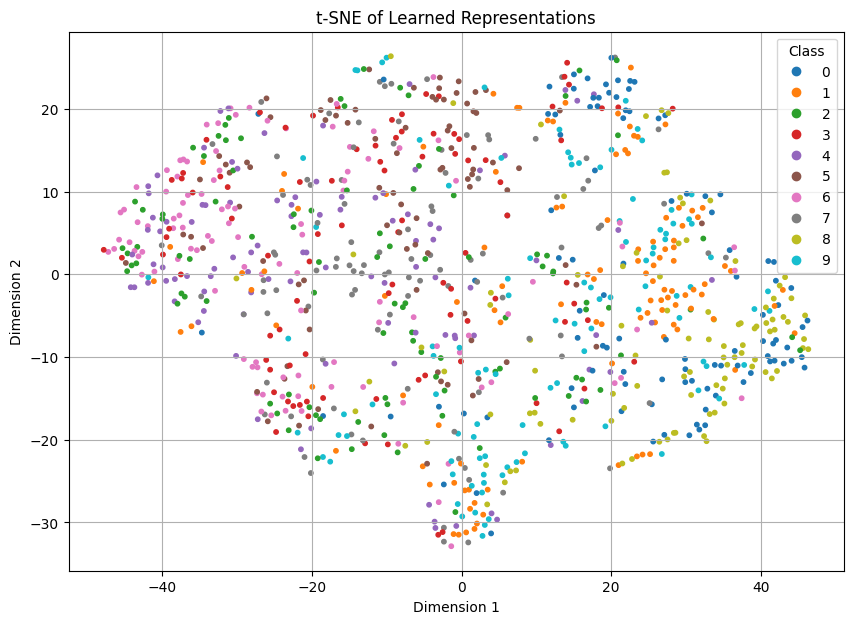

In [16]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def visualize_embeddings(model, dataset, n_samples=1000):
    model.eval()
    X, Y = [], []

    with torch.no_grad():
        for i in range(n_samples):
            x, y = dataset[i]
            x = transform(x).unsqueeze(0).to(device)
            z = model(x).cpu().numpy()[0]
            X.append(z)
            Y.append(y)

    X = np.array(X)
    Y = np.array(Y)
    X_emb = TSNE(n_components=2, perplexity=30).fit_transform(X)

    # X_emb = TSNE(n_components=2).fit_transform(X)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_emb[:, 0], X_emb[:, 1], c=Y, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title("t-SNE of Learned Representations")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.grid(True)
    plt.show()

# Run it
visualize_embeddings(model, base_dataset)

### UMAP (Uniform Manifold Approximation and Projection)

In [ ]:
import umap.umap_ as umap

def visualize_embeddings_umap(model, dataset, n_samples=1000):
    model.eval()
    X, Y = [], []

    with torch.no_grad():
        for i in range(n_samples):
            x, y = dataset[i]
            x = transform(x).unsqueeze(0).to(device)
            z = model(x).cpu().numpy()[0]
            X.append(z)
            Y.append(y)

    X = np.array(X)
    Y = np.array(Y)
    X_emb = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine').fit_transform(X)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_emb[:, 0], X_emb[:, 1], c=Y, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title("UMAP of Learned Representations")
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.grid(True)
    plt.show()


### PCA (Principal Component Analysis)

In [ ]:
from sklearn.decomposition import PCA

def visualize_embeddings_pca(model, dataset, n_samples=1000):
    model.eval()
    X, Y = [], []

    with torch.no_grad():
        for i in range(n_samples):
            x, y = dataset[i]
            x = transform(x).unsqueeze(0).to(device)
            z = model(x).cpu().numpy()[0]
            X.append(z)
            Y.append(y)

    X = np.array(X)
    Y = np.array(Y)
    X_emb = PCA(n_components=2).fit_transform(X)

    plt.figure(figsize=(10, 7))
    scatter = plt.scatter(X_emb[:, 0], X_emb[:, 1], c=Y, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Class")
    plt.title("PCA of Learned Representations")
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.grid(True)
    plt.show()
